In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from core1d import rule_hamiltonian
from states import make_state
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import multi_dot
from scipy.linalg import expm
from matrix import op_at, dagger
from measures import expectation
from time import time
%matplotlib inline

# Simulation paramters

In [2]:
L = 11  # System size
T = 10  # Final time
dt = 0.1  # Time resolution

betas = [0.0, 0.5, 1.0]  # Inverse temperatures
Rs = [1, 6, 13, 14]  #Rule numbers

correlates = ["XX", "ZZ", "XZ"]


# Time info
Ti = int(T/dt) + 1 # Number of points along the time axis
ts = np.arange(Ti)*dt  # Time axis data

# Generate data

In [ ]:
# Dictonary for storing results
OTOCs = {}

# time stamp for 
t0 = time()
# Operator loop
for AB in correlates:
    Astr, Bstr = AB
    OTOC = np.zeros((len(Rs), len(betas), Ti, L))

    # Rule number loop
    for Ri, R in enumerate(Rs):
        H = rule_hamiltonian(V="X", R=R, L=L, r=1, BC="0")
        U = expm(-1j*H*dt)

        # Inverse temperature loop
        for betai, beta in enumerate(betas):
            # calculate thermal state and partition function once
            Q = expm(-beta*H)
            Z = np.trace(Q)
            
            
            # Expectation value w.r.t thermal state
            def thermal_exp(O):
                return np.trace(Q.dot(O)) / Z

            # Space loop
            for j in range(L):
                print(AB, R, beta, j, time()-t0)
                # Operators
                A = op_at(Astr, j, L)
                Bt = op_at(Bstr, int(L/2), L)
                OTOC[Ri, betai, 0, j] = 1 - thermal_exp(multi_dot([Bt, A, Bt, A])).real

                # Time loop
                for ti in range(1, Ti):
                    Bt = multi_dot([dagger(U), Bt, U])
                    OTOC[Ri, betai, ti, j] = 1 - thermal_exp(multi_dot([Bt, A, Bt, A])).real
    OTOCs[AB] = OTOC

# Save data

In [ ]:
for AB in ["XX", "ZZ", "XZ"]:
    OTOC = OTOCs[AB]
    with open(f"thermo-figures/{AB}_OTOC.dat", 'wb') as f:
        np.save(f, OTOC)
        

# Load data

In [4]:
OTOCs= {}
for AB in ["XX", "ZZ", "XZ"]:
    for Ri, R in enumerate(Rs):
        for betai, beta in enumerate(betas):
            with open(f"thermo-figures/{AB}_OTOC.dat", 'rb') as f:
                OTOC = np.load(f, allow_pickle=True)
                OTOCs[AB] = OTOC

# Analysis

## Overview

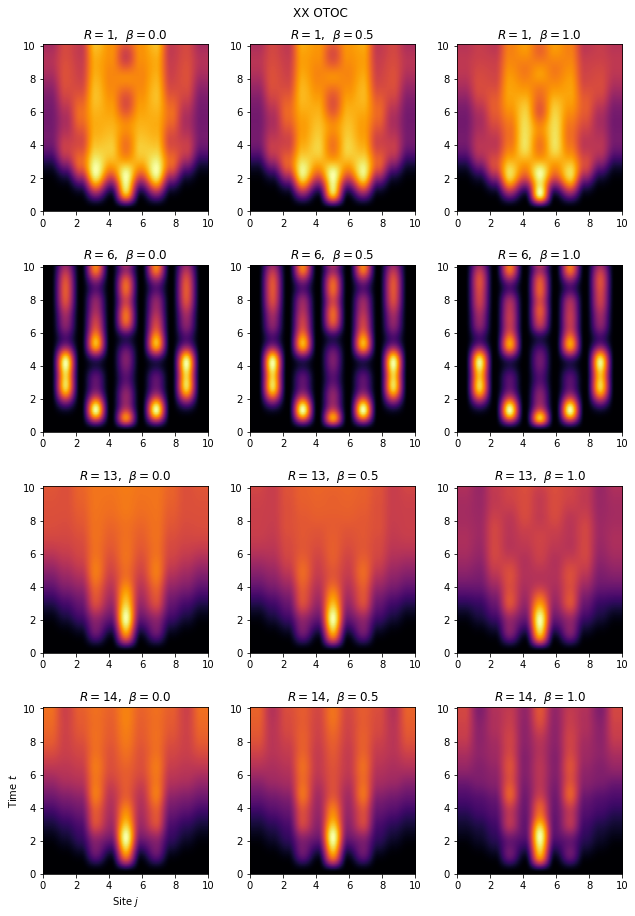

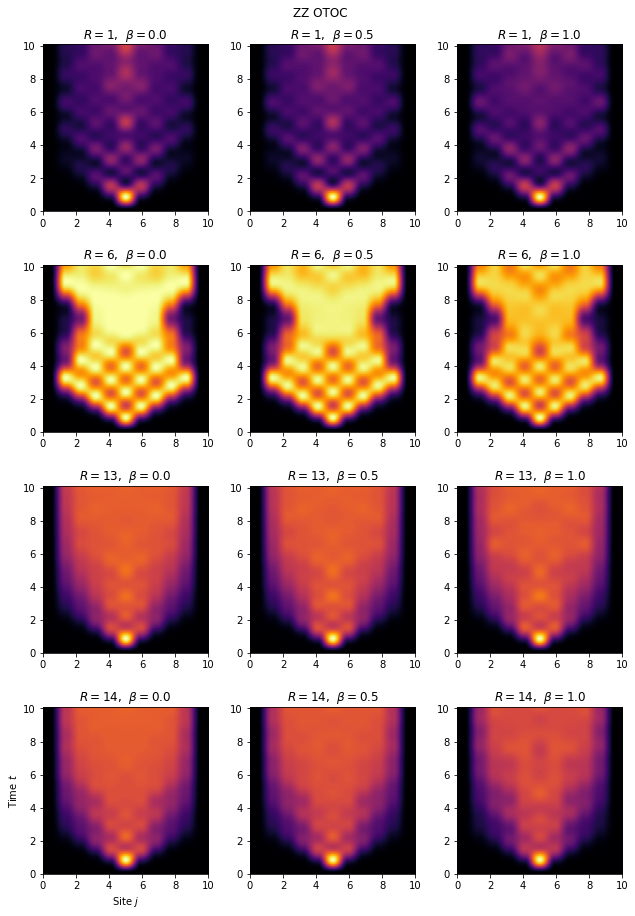

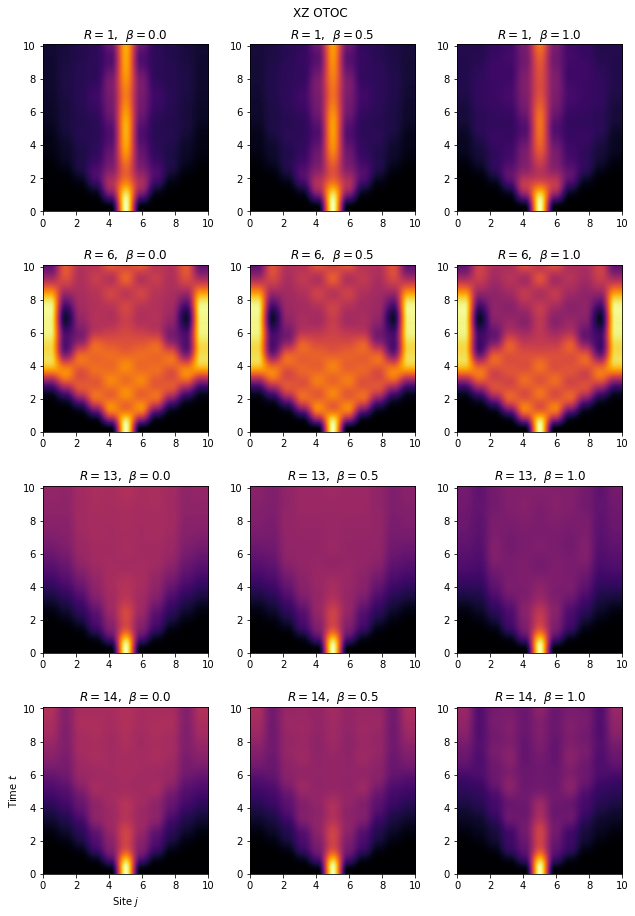

In [7]:
for AB in ["XX", "ZZ", "XZ"]:
    fig, axs = plt.subplots(len(Rs), len(betas), figsize=(9, 13))
    for Ri, R in enumerate(Rs):
        for betai, beta in enumerate(betas):            
            OTOC = OTOCs[AB][Ri, betai]
            axs[Ri, betai].imshow(OTOC, origin="lower", extent=[0,L-1,0, Ti*dt], cmap="inferno")
            axs[Ri, betai].set_title(r"$R=%s$,  $\beta=%s$" % (R, beta))

    axs[-1, 0].set_ylabel("Time $t$")
    axs[-1, 0].set_xlabel("Site $j$")
    plt.suptitle(f"{AB} OTOC")
    plt.tight_layout()

## Temperature dependence

In [9]:
from figures import colors

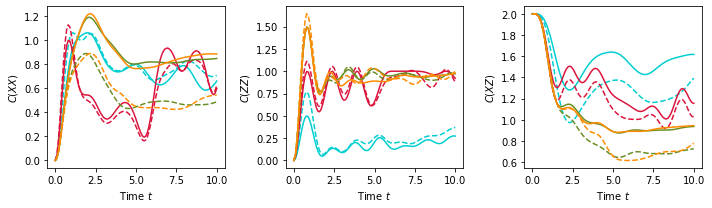

In [37]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for ABi, AB in enumerate(correlates):
    ax = axs[ABi]
    ax.set_ylabel(r"$C(%s)$" % AB)
    ax.set_xlabel("Time $t$")
    for Ri, R in enumerate(Rs):
        for betai, ls in zip([0, -1], ["-", "--"]):            
            OTOC = OTOCs[AB][Ri, betai]
            ax.plot(ts, OTOC[::, int(L/2)], color=colors[R], ls=ls)
plt.tight_layout()

OTOC $C$ for site $j = L/2 = 5$. Infinte temperature ($\beta=0$): solid line, low temperature ($\beta=1$): dashed line. Colors differentiate rules ($T_1$: cyan, $T_6$: ruby, $T_{13}$: green, $T_{14}$: orange. 

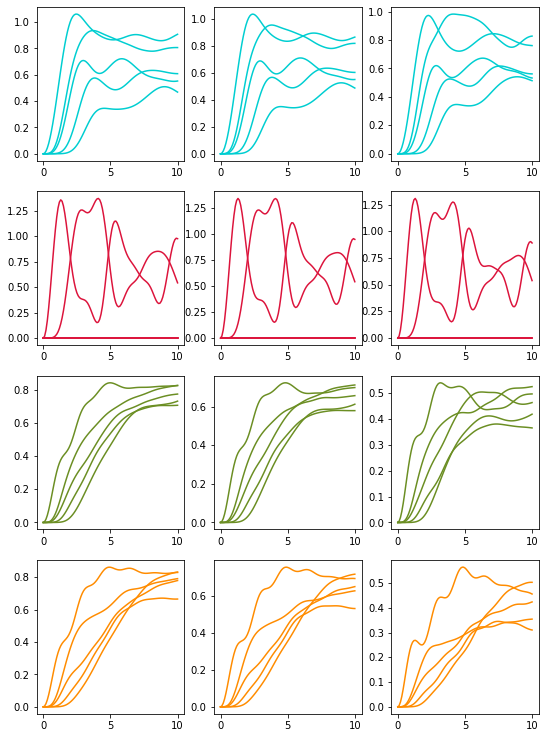

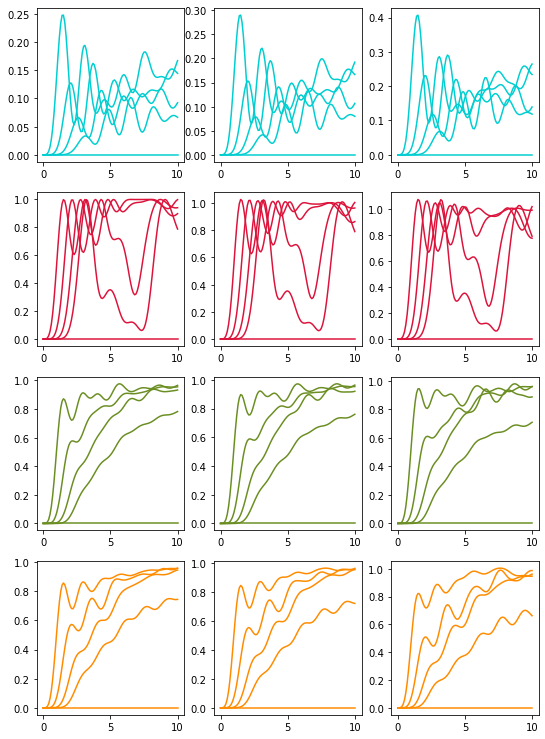

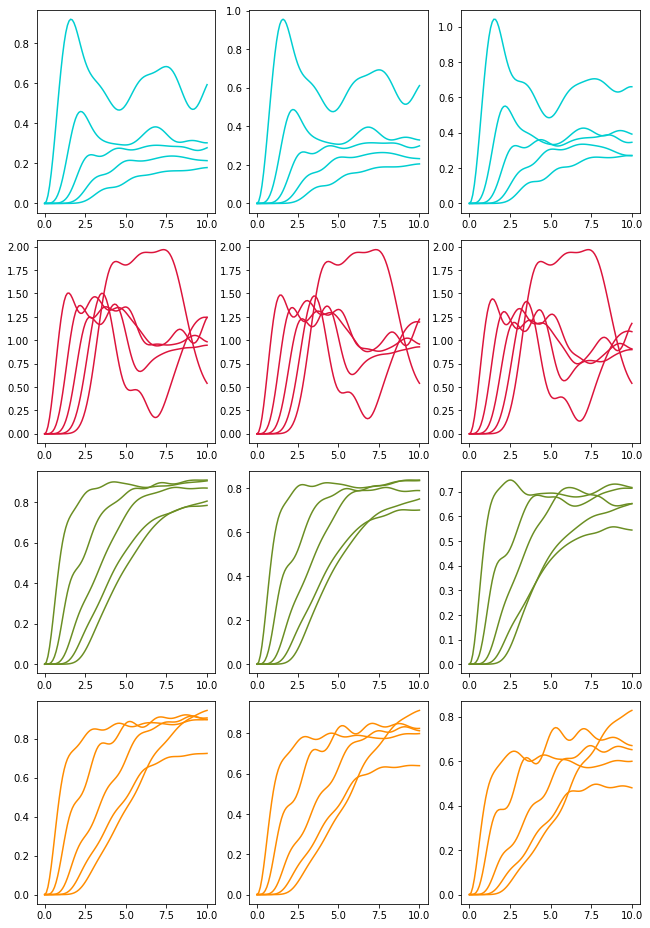

In [66]:
for AB in ["XX", "ZZ", "XZ"]:
    fig, axs = plt.subplots(len(Rs), len(betas), figsize=(9, 13))
    for Ri, R in enumerate(Rs):
        for betai, beta in enumerate(betas):            
            OTOC = OTOCs[AB][Ri, betai]
            ax = axs[Ri, betai]
            for d in range(1, 6):
                ax.plot(ts, OTOC[::, int(L/2)+d], color=colors[R])
plt.tight_layout()

# Z2 Scar

In [8]:
L = 10
H = rule_hamiltonian(V="X", R=1, L=L, r=1, BC="0")

In [2]:
for R in range(16):
    L = 9
    H = rule_hamiltonian(V="X", R=6, L=L, r=1, BC="0")
    from matrix import listkron, ops
    P = listkron([ops["Z"] for i in range(L)])
    print(np.allclose(H.dot(P) + P.dot(H), np.zeros_like(H)))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
overlap = np.array([np.abs(np.vdot(vecs[:, i], Z2)).real**2 for i, v in enumerate(vals)])

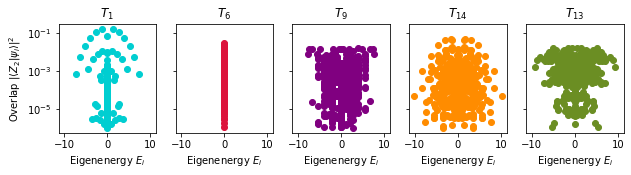

In [25]:
from figures import colors, names
L = 12
fig, axs = plt.subplots(1, 5, figsize=(3*3.375, 2), sharey=True, sharex=True)
for Ri, R in enumerate([1, 6, 9, 14, 13]):
    ax = axs[Ri]
    H = rule_hamiltonian(V="X", R=R, L=L, r=1, BC="0")
    
    vals, vecs = np.linalg.eigh(H)
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs =vecs[:,idx]
    Z2 = make_state(L, "d2")
    overlap = np.array([np.abs(np.vdot(vecs[:, i], Z2)).real**2 for i, v in enumerate(vals)])
    
    mask = np.array(overlap)>1e-6
    ax.scatter(vals[mask], overlap[mask], c=colors[R])
    ax.set_title(names[R])
    ax.set_yscale("log")
    ax.set_xlabel("Eigenenergy $E_i$")
    if Ri == 0:
        ax.set_ylabel(r"Overlap $| \langle Z_2 | \psi_i \rangle |^2$")
plt.savefig("figures/scars.pdf", bbox_inches="tight")

/home/lhillber/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lhillber/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


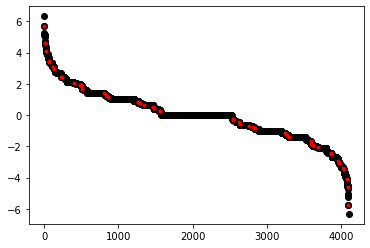

In [168]:
plt.plot(np.arange(len(vals)), vals, marker="o", c="k", ls="none")
plt.plot(np.arange(len(vals))[mask], vals[mask], marker=".", c="r", ls="none")

In [169]:
from measures import get_ebisect, renyi_entropy_from_spectrum
s_2 = []
for i, vec in enumerate(vecs):
    espec = np.sort(get_ebisect(vec))
    s_2.append(renyi_entropy_from_spectrum(espec))
s_2 = np.array(s_2)
    

4095
4094
4093
4092
4091
4090
4089
4088
4087
4086
4085
4084
4083
4082
4081
4080
4079
4078
4077
4076
4075
4074
4073
4072
4071
4070
4069
4068
4067
4066
4065
4064
4063
4062
4061
4060
4059
4058
4057
4056
4055
4054
4053
4052
4051
4050
4049
4048
4047
4046
4045
4044
4043
4042
4041
4040
4039
4038
4037
4036
4035
4034
4033
4032
4031
4030
4029
4028
4027
4026
4025
4024
4023
4022
4021
4020
4019
4018
4017
4016
4015
4014
4013
4012
4011
4010
4009
4008
4007
4006
4005
4004
4003
4002
4001
4000
3999
3998
3997
3996
3995
3994
3993
3992
3991
3990
3989
3988
3987
3986
3985
3984
3983
3982
3981
3980
3979
3978
3977
3976
3975
3974
3973
3972
3971
3970
3969
3968
3967
3966
3965
3964
3963
3962
3961
3960
3959
3958
3957
3956
3955
3954
3953
3952
3951
3950
3949
3948
3947
3946
3945
3944
3943
3942
3941
3940
3939
3938
3937
3936
3935
3934
3933
3932
3931
3930
3929
3928
3927
3926
3925
3924
3923
3922
3921
3920
3919
3918
3917
3916
3915
3914
3913
3912
3911
3910
3909
3908
3907
3906
3905
3904
3903
3902
3901
3900
3899
3898
3897
3896


2448
2447
2446
2445
2444
2443
2442
2441
2440
2439
2438
2437
2436
2435
2434
2433
2432
2431
2430
2429
2428
2427
2426
2425
2424
2423
2422
2421
2420
2419
2418
2417
2416
2415
2414
2413
2412
2411
2410
2409
2408
2407
2406
2405
2404
2403
2402
2401
2400
2399
2398
2397
2396
2395
2394
2393
2392
2391
2390
2389
2388
2387
2386
2385
2384
2383
2382
2381
2380
2379
2378
2377
2376
2375
2374
2373
2372
2371
2370
2369
2368
2367
2366
2365
2364
2363
2362
2361
2360
2359
2358
2357
2356
2355
2354
2353
2352
2351
2350
2349
2348
2347
2346
2345
2344
2343
2342
2341
2340
2339
2338
2337
2336
2335
2334
2333
2332
2331
2330
2329
2328
2327
2326
2325
2324
2323
2322
2321
2320
2319
2318
2317
2316
2315
2314
2313
2312
2311
2310
2309
2308
2307
2306
2305
2304
2303
2302
2301
2300
2299
2298
2297
2296
2295
2294
2293
2292
2291
2290
2289
2288
2287
2286
2285
2284
2283
2282
2281
2280
2279
2278
2277
2276
2275
2274
2273
2272
2271
2270
2269
2268
2267
2266
2265
2264
2263
2262
2261
2260
2259
2258
2257
2256
2255
2254
2253
2252
2251
2250
2249


753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
736
735
734
733
732
731
730
729
728
727
726
725
724
723
722
721
720
719
718
717
716
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658
657
656
655
654
653
652
651
650
649
648
647
646
645
644
643
642
641
640
639
638
637
636
635
634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504


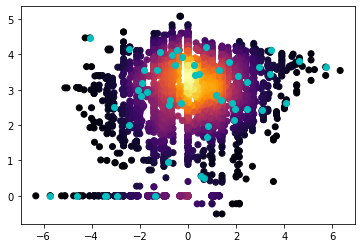

In [171]:
from scipy.stats import gaussian_kde
s_2 = np.array(s_2)
x, y = vals.real, s_2
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=z, cmap="inferno")
plt.scatter(vals[mask], s_2[mask], c="c")